In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
from pymc.ode import DifferentialEquation

from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print

from scipy.integrate import odeint


(20, 2)

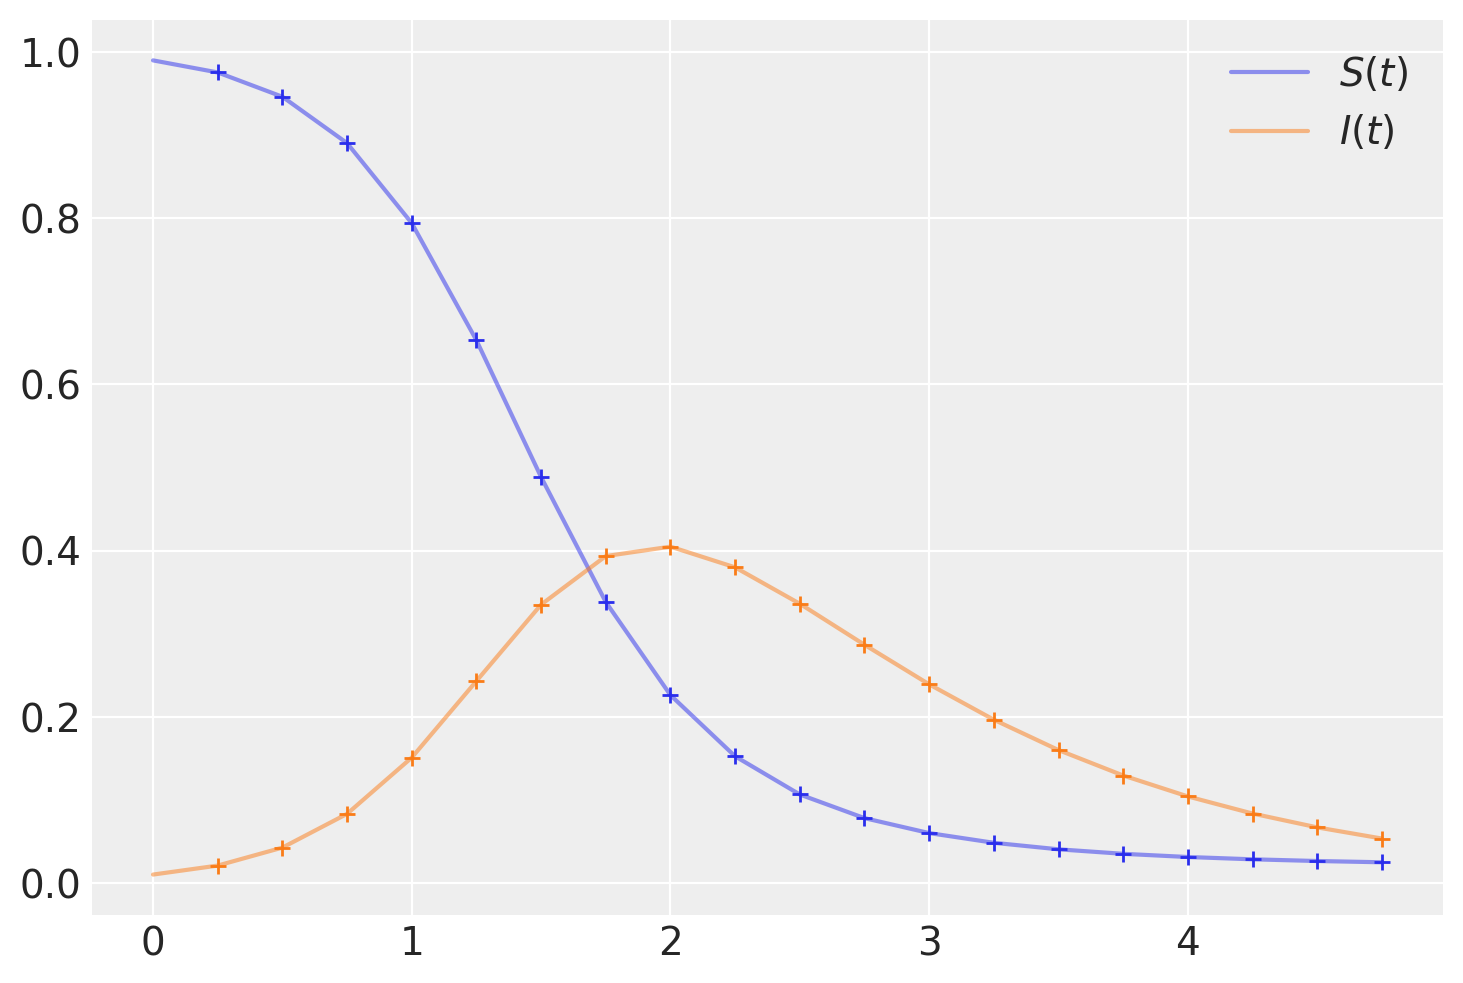

(19, 2)

(20,)

In [8]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]


times = np.arange(0, 5, 0.25)

beta, gamma = 4, 1.0

# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)


print(y.shape)

# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

yobs = y[1:]
# plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times[1:], yobs, marker="+", linestyle="none")

plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$S(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$I(t)$")
plt.legend()
plt.show()


print(yobs.shape,times.shape)

In [9]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

model4 = pm.Model()
with model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)
    # R0 is bounded below by 1 because we see an epidemic has occurred
    # R0 = pm.Bound(pm.Normal, lower=1)("R0", 2, 3)
    R0 = pm.Normal("R0", 2, 3)
    
    lam = pm.Lognormal("lambda", pm.math.log(2), 2)
    beta = pm.Deterministic("beta", lam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal("Y", mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)



In [10]:
idata = pm.sample(2000, tune=1000, target_accept=0.9, model= model4)

ValueError: Not enough samples to build a trace.

In [ ]:
az.plot_posterior(idata, round_to=2);